In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import trapz
from scipy.interpolate import RegularGridInterpolator

from IPython.core.display import HTML
from tqdm.notebook import tqdm

import warnings
# suppress warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0

# References
- [1] : `2020` Large colloidal probes for atomic force microscopy: Fabrication and calibration issues. Chighizola, et al. ([link](https://doi.org/10.1002/jmr.2879))
- [2] : `2013` Functionalized AFM probes for force spectroscopy: eigenmode shapes and stiffness calibration through thermal noise measurements. Lauerent, et al. ([link](https://doi.org/10.1088/0957-4484/24/22/225504))
- [3] : `2006` Force measurements with the atomic force microscope: Technique, interpretation and applications. Butt, Cappella, Kappl ([link](https://doi.org/10.1016/j.surfrep.2005.08.003))
- [4] : `1995` Calculation of thermal noise in atomic I force microscopy. Butt, Jaschke. ([link](https://doi.org/10.1088/0957-4484/6/1/001))

# Introducing $\tilde{m}$ and $\tilde{r}$ [1]

- $\tilde{m}=m_s/m_c$ reduced mass, is the ratio of colloid mass to that of the cantilever.
- $\tilde{r}=r_g/L=\sqrt{7/2}R_s/L$ reduced gyration radius.

For $\tilde{m}$ and $\tilde{r}$ above 0, the basic cantilever calibration parameters such as the resonant frequency $\nu_0$, the quality factor $Q$, the deflection sensitivity $S_z$, the spring
constant $k$, depend on $\tilde{m}$ and $\tilde{r}$.

# Flexural eigenmodes of a clamped cantilever [2]

Conditions:
> We neglect in our analysis any offset along the cantilever axis and any coupling with torsion: precise gluing of the bead should make those effects negligible in a first approximation. In order to reach a simple analytical solution, we also neglect the actual triangular shape of the cantilever at its free end: we will consider that the lever has an effective length smaller than its total length to approximate the real geometry. This last approximation will prove to be reasonable to describe our measurements.

Euler–Bernoulli beam with mass added to free end of cantilever.

The equation of motion for the cantilever, once the variables in time and space are separated, can be written as

$$
\frac{k}{3}\frac{d^4z}{dx^4} = m_c\omega^2z
$$

With $k$ the static stiffness of the cantilever, $m_c$ its mass, $Z(x,t)=z(x)\exp{i\omega t}$ the deflection, and $\omega$ the angular frequency. This equation can be rewritten as

$$
z^{(4)}=\alpha^4 z
$$

Where $^{(n)}$ is the spatial derivative of order $n$, $\alpha$ is given by the dispersion relation:

$$
\alpha^4 = \frac{3m_c\omega^2}{k}.
$$

The generic solution to this equation is

$$
z(x) = a\cos{\alpha x} + b \sin{\alpha x} - c\cosh{\alpha x} - d\sinh{\alpha x}.
$$

The boundary conditions $x=0$ correspond to a clamped end, implying $z(0)=0$ and $z^{(1)}(0) = 0$, hence $a=c$ and $b=d$. Defining $R=b/a$, the expression above can thus be written as

$$
z(x) = a(\cos{\alpha x} - \cosh{\alpha x} + R\left[\sin{\alpha x} - \sinh{\alpha x}\right]).
$$

For $x=1$, corresponding to the free end of the cantilever where the bead is glued, the conditions on the force and torque are linked to the inertia in translation and rotation of the bead [19]:

$$
z^{(3)}(1) = -\alpha^4\tilde{m}z(1);\quad z^{(2)}(1) = \alpha^4\tilde{m}\tilde{r}^2z^{(1)}(1)
$$

where $\tilde{m}=m_b/m_c$ is the mass of the bead $m_b$ normalized to that of the cantilever $m_c$, and $\tilde{r}=r_g/L$ is the gyration radius of the bead $r_g$ normalized to the cantilever length $L$. Expressing these boundary conditions with the expression found for $z$ leads to

$$
R = \frac{\sin\alpha - \sinh\alpha + \alpha \tilde{m} (\cos\alpha - \cosh\alpha)}{\cos\alpha + \cosh\alpha - \alpha \tilde{m}(\sin\alpha - \sinh\alpha)} = -\frac{\cos\alpha + \cosh\alpha - \alpha^3\tilde{m}\tilde{r}^2(\sin\alpha + \sinh\alpha)}{\sin\alpha + \sinh\alpha + \alpha^3\tilde{m}\tilde{r}^2(\cos\alpha - \cosh\alpha)}
$$

The values of α allowing this equality are quantified, and correspond to the spatial eigenvalues $\alpha_n(\tilde{m}, \tilde{r})$ of the resonant modes of the cantilever.

Calculating literature eigenmodes for "classic" cantilever without mass (tipless cantilever)

Values for $\alpha_i$ from [3]:
- $\alpha_1 = 1.875$
- $\alpha_2 = 4.694$
- $\alpha_3 = 7.855$
- $\alpha_4 = 10.996$
- $\alpha_5 = 14.137$

# Eigenvalue solver
To solve eigenvalues $\alpha$, we can use the equality for $R$. Let's first plot the left side minus the right side in the equation for $R$ 

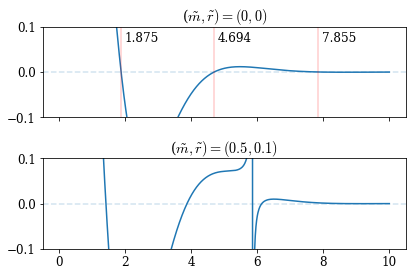

In [3]:
def R(x, m, r):
    ''' R equality '''
    # left side A/B
    A = np.sin(x) - np.sinh(x) + x*m*(np.cos(x) - np.cosh(x))
    B = np.cos(x) + np.cosh(x) - x*m*(np.sin(x) - np.sinh(x))
    
    # right side -C/D
    C = np.cos(x) + np.cosh(x) - x**3 * m * r**2 * (np.sin(x) + np.sinh(x))
    D = np.sin(x) + np.sinh(x) + x**3 * m * r**2 * (np.cos(x) - np.cosh(x))
    
    return A/B + C/D

x = np.linspace(0.01, 10, 1000)
y0 = R(x, 0, 0)
y1 = R(x, .5, .1)

α0 = [1.875, 4.694, 7.855]

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

ax[0].plot(x, y0)
ax[0].axhline(0, linestyle='--', alpha=.2)
ax[0].set_title(r'($\tilde{m},\tilde{r}) = (0,0)$')
for αi in α0:
    ax[0].axvline(αi, color='r', alpha=.2)
    ax[0].text(αi+0.1, 0.09, f'{αi}', va='top')

ax[1].plot(x, y1)
ax[1].axhline(0, linestyle='--', alpha=.2)
ax[1].set_title(r'($\tilde{m},\tilde{r}) = (0.5,0.1)$')

ax[0].set_ylim(-1e-1, 1e-1)

fig.tight_layout()

We can see how intercepts with the x-axis are solutions for $\alpha$. In case of increased $\tilde{m}$-$\tilde{r}$, an asymtote is introduced. 

To find the roots, we calculate `N` points along the curve in the interval `[a,b]`. Upon walking along the curve, intersection with the `x`-axis is detected by a change of sign in $y$. Having detected a crossing of the $x$-axis, the domain is bisected using a bisection algorithm to find the root with greater accuracy. This bisection algorithm is stopped once a certain margain of error is attained (`eps`).

In [4]:
from utils import *

def eigenmodes(m, r, a=0.01, b=10, N=1000, n=3, eps=1e-6, max_iter=100):
    ''' Solving eigenmodes α using equality R
    
    Args:
        m (float) : reduced mass.
        r (float) : reduced gyration radius.
        a (float) : start of interval.
        b (float) : end of interval.
        N (int) : no. points on curve.
        n (int) : no. eigenvalues to be found in interval [a,b].
        eps (float) : cutoff margin of error for finding root in bisection method.
        max_iter (int) : max no. miterations in bisection method.
    Returns:
        α (array) : eigenvalues found (n,1).
    Warns:
        ConvergenceWarning: If can't converge within error margin `eps` for maximum number of iterations `max_iter`. 
    
    '''
    def R(x):
        # equality $R$
        nonlocal m, r
        A = np.sin(x) - np.sinh(x) + x*m*(np.cos(x) - np.cosh(x))
        B = np.cos(x) + np.cosh(x) - x*m*(np.sin(x) - np.sinh(x))

        C = np.cos(x) + np.cosh(x) - x**3 * m * r**2 * (np.sin(x) + np.sinh(x))
        D = np.sin(x) + np.sinh(x) + x**3 * m * r**2 * (np.cos(x) - np.cosh(x))
                
        return A/B + C/D
    
    # walking along R with steps of `dx`
    dx = (b - a)/N
    # starting from position `a`
    x = a
       
    # initializing `α` array for found eigenvalues
    i = 0
    α = np.asarray([float('nan')] * n)
        
    # start waling along the curve
    for _ in range(N):
        # if we cross a sign change between `x` and `x+dx`, we might find a root
        if R(x)*R(x + dx) < 0:
            # use bisection algorithm to estimate root on interval [`x`,`x+dx`]
            ai, bi = x, x+dx
        
            for _ in range(max_iter):
                # interval midpoint `m`
                mi = (ai + bi)/2

                # if root found within error margin `eps` return `m`
                if abs(R(mi)) < eps:
                    α[i] = mi
                    break
                # else update interval
                else:
                    # root between `a` and `m` (checking by sign change)
                    if R(ai)*R(mi) < 0:
                        bi = mi
                    # otherwise root is between `m` and `b`
                    else:
                        ai = mi
            
            # catch asymtote
            if -R(ai)*R(bi) > 1:
                asym = mi
                i -= 1
            # solution not found in maximum iterations
            elif np.isnan(α[i]):
                convergencewarning(eps, max_iter, mi, R)
                α[i] = mi
            
            # find next eigenvalue
            i += 1
        
        if i == n:
            return α
        
        x += dx
        

α = eigenmodes(0,0, eps=1e-6, max_iter=100)

print(eigenmodes(m=0, r=0).round(3))

[1.875 4.694 7.855]


Values found correspond to literature values for $(\tilde{m},\tilde{r})=(0,0)$.

Calculating first three modes for different $\tilde{m}$

In [5]:
def z_i(x, m, r, a_i):
    A = np.sin(a_i) - np.sinh(a_i) + a_i*m*(np.cos(a_i) - np.cosh(a_i))
    B = np.cos(a_i) + np.cosh(a_i) - a_i*m*(np.sin(a_i) - np.sinh(a_i))

    R = A/B

    z = np.cos(a_i*x) - np.cosh(a_i*x) + R*(np.sin(a_i*x) - np.sinh(a_i*x))
    
    return z

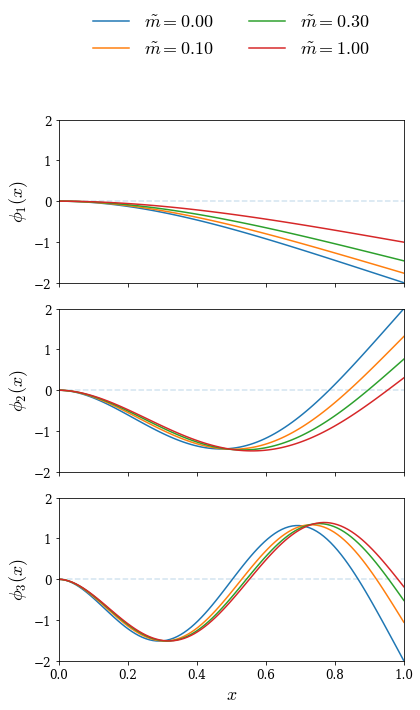

In [6]:
M = [0,0.1,0.3,1] # masses
A = np.asarray([eigenmodes(M[i], 0) for i in range(len(M))])

x = np.linspace(0, 1, 100)

fig, ax = plt.subplots(A.shape[1], 1, figsize=(6,10), sharex=True)

for j in range(A.shape[1]):
    ax[j].axhline(0, linestyle='--', alpha=.2)
    
    for i in range(len(M)):
        ax[j].plot(x, z_i(x, M[i], 0, A[i,j]), label=r'$\tilde{m}=' + f'{M[i]:.2f}$')
    
    ax[j].set_ylim(-2,2)
    ax[j].set_xlim(0,1)
    
    ax[j].set_ylabel(fr'$\phi_{j+1}(x)$', fontsize=18)
        
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2, frameon=False, fontsize=18)

ax[-1].set_xlabel('$x$', fontsize=18)

fig.tight_layout()

Curves correspond to cuvres in Fig. 2 [2]. A problem for the numerical calculation of $\alpha$ arises for $\tilde{r}>0$ in modes above 1 using this algorithm due to presence of asymtotes.

Tabulated values for the first mode ($0\leq\tilde{m}\leq 2$; $0\leq\tilde{r}\leq{0.1}$) found in the online supplementary of paper [2] all correspond to values found using this algorithm ([Supplementary data](https://iopscience.iop.org/article/10.1088/0957-4484/24/22/225504/data)).

In [7]:
M = np.linspace(0, 2, 21)
R = np.linspace(0, 0.1, 11)

α = np.zeros((M.size, R.size))

for i, m in enumerate(M):
    for j, r in enumerate(R):
        α[i,j] = eigenmodes(m, r, N=100)[0]
        
pd.DataFrame(α.round(4), index=M, columns=R)

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
0.0,1.8751,1.8751,1.8751,1.8751,1.8751,1.8751,1.8751,1.8751,1.8751,1.8751,1.8751
0.1,1.7227,1.7227,1.7226,1.7225,1.7223,1.7221,1.7218,1.7215,1.7212,1.7207,1.7203
0.2,1.6164,1.6164,1.6163,1.6161,1.6158,1.6155,1.6151,1.6146,1.6140,1.6134,1.6127
0.3,1.5361,1.5361,1.5360,1.5357,1.5354,1.5350,1.5345,1.5340,1.5333,1.5325,1.5317
0.4,1.4724,1.4724,1.4722,1.4720,1.4716,1.4712,1.4707,1.4700,1.4693,1.4685,1.4676
0.5,1.4200,1.4199,1.4198,1.4195,1.4191,1.4187,1.4181,1.4175,1.4167,1.4158,1.4149
0.6,1.3757,1.3756,1.3755,1.3752,1.3748,1.3744,1.3738,1.3731,1.3723,1.3714,1.3704
0.7,1.3375,1.3374,1.3373,1.3370,1.3366,1.3362,1.3356,1.3349,1.3341,1.3332,1.3321
0.8,1.3041,1.3040,1.3039,1.3036,1.3032,1.3027,1.3021,1.3014,1.3006,1.2997,1.2987
0.9,1.2745,1.2744,1.2742,1.2740,1.2736,1.2731,1.2725,1.2718,1.2710,1.2700,1.2690


# Normalization of eigenmodes

Before we can obtain $\beta^*$ we first need to normalize $z_n(x)$; find $a_n$.

Normalizing condition:

$$
\int_0^1 \left|\phi_n(x)\right|^2 dx = 1
$$

Defining

$$
z_n(x) = a_n\zeta_n(x) = a_n(\cos\alpha_nx - \cosh\alpha_nx + R_n[\sin\alpha_nx - \sinh\alpha_nx])
$$

The paper presents the following eq. for normalization[2]:

$$
\frac{1}{a_n^2} = \int_0^1 \zeta_n^2(x)dx + \tilde{m}\zeta_n^2(1) + \tilde{m}\tilde{r}^2\zeta_n^{\prime 2}(1)
$$

numerical normalization:

In [8]:
# taking random m, r
m = 1
r = .1

a1 = eigenmodes(m,r)[0]

A = np.sin(a1) - np.sinh(a1) + a1*m*(np.cos(a1) - np.cosh(a1))
B = np.cos(a1) + np.cosh(a1) - a1*m*(np.sin(a1) - np.sinh(a1))

R = A/B

In [9]:
x = np.linspace(0,1,100)
z = np.cos(a1*x) - np.cosh(a1*x) + R*(np.sin(a1*x) - np.sinh(a1*x))

dzdx = a1*(-np.sin(a1)-np.sinh(a1)+R*(np.cos(a1)-np.cosh(a1)))
# numerical
A1_num = 1 / np.sqrt(trapz(z**2, x) + m*z[-1]**2 + m*r**2*dzdx**2)

HTML(r'$a_\mathrm{1,numeric} = %.4f$ for $\tilde{m}=%.1f$ and $\tilde{r}=%.1f$' %(A1_num, m, r))

# Correction factor $\beta^*$

From Butt, Cappella, Kappl[3] definition $\beta$ (measuring delfection)

$$
    \beta = \frac{12}{\alpha_1^4};\quad\left<z_1\right>^2 = \beta \frac{k_BT}{k}
$$

For measuring using inclination $\beta^*$ is slightly different than $\beta$. However, inclination is proportional to deflection by:

$$
\beta^* = \frac{3}{\alpha_1^4} \left( \frac{z_d^\prime(x)}{z_s^\prime(x)} \right)^2;\quad\left<z_1^*\right>^2 = \beta^* \frac{k_BT}{k}
$$

Normalized static deflection

$$
z_s(x) = \frac{1}{2} (x-2) x^2\quad z_s^\prime(x) = \frac{x(3x - 6)}{2}
$$

Dynamic deflection as derived from before (mode 1)

$$
z_{d,1}(x) = a_1(\cos\alpha_1x - \cosh\alpha_1x + R_1\left[\sin\alpha_1x - \sinh\alpha_1x\right])
$$

Since $dR_n/dx = 0$ we can easily obtain its slope:

$$
z^\prime_{d,1} = a_1\alpha_1(-\sin\alpha_1x - \sinh\alpha_1x + R_1\left[\cos\alpha_1x - \cosh\alpha_1x\right])
$$

Finally calculating $\beta^*$, for laser beam position on cantilever $x\in[0,1]$

$$
\beta^* = \frac{3}{\alpha_1^4} \left( \frac{z_d^\prime(x)}{z_s^\prime(x)} \right)^2
$$

In [10]:
def beta(m, r, x=1):
    α1 = eigenmodes(m, r, b=8, n=1)[0]
    
    A = np.sin(α1) - np.sinh(α1) + α1*m*(np.cos(α1) - np.cosh(α1))
    B = np.cos(α1) + np.cosh(α1) - α1*m*(np.sin(α1) - np.sinh(α1))

    R = A/B
    R2 = R**2
    
    # normalization factor
#     A1 = 1/np.sqrt(m*(np.cos(a1)-np.cosh(a1)+R*(np.sin(a1)-np.sinh(a1)))**2+m*r**2*a1**2*(-np.sin(a1)-np.sinh(a1)+R*(np.cos(a1)-np.cosh(a1)))**2-(np.exp(-2*a1)*((2*R2-2)*np.exp(2*a1)*np.sin(2*a1)+4*R*np.exp(2*a1)*np.cos(2*a1)+((4*R2+8*R+4)*np.exp(3*a1)+(4*R2-8*R+4)*np.exp(a1))*np.sin(a1)+((4-4*R2)*np.exp(3*a1)+(4*R2-4)*np.exp(a1))*np.cos(a1)+(-R2-2*R-1)*np.exp(4*a1)-8*a1*np.exp(2*a1)+R2-2*R+1))/(8*a1))
    x_num = np.linspace(0,1,100)
    z_num = np.cos(α1*x_num) - np.cosh(α1*x_num) + R*(np.sin(α1*x_num) - np.sinh(α1*x_num))
    
    dzdx_num = α1*(-np.sin(α1)-np.sinh(α1)+R*(np.cos(α1)-np.cosh(α1)))
    # numerical
    A1 = 1 / np.sqrt(trapz(z_num**2, x_num) + m*z_num[-1]**2 + m*r**2*dzdx_num**2)
        
    # dynamic deflection slope
    dzdx_d = A1*α1*(-np.sin(α1*x)-np.sinh(α1*x)+R*(np.cos(α1*x)-np.cosh(α1*x)))
    # static deflection slope
    dzdx_s = (6*x-3*x**2)/2

    beta =  3/(α1**4) * (dzdx_d/dzdx_s)**2

    return beta

HTML(r'$\beta^*=%.3f$ for $\tilde{m}=\tilde{r}=0$ which satisfies the literature value for tipless cantilevers.' %beta(0,0))

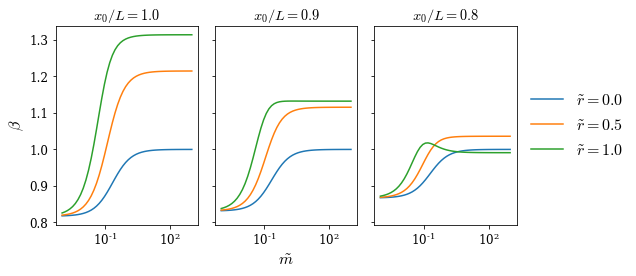

In [11]:
M = np.logspace(-3, 3, 50)
R = [0, .5, 1]
X = [1,0.9,0.8]

m, n = len(R), len(X)

fig, ax = plt.subplots(1, n, figsize=(9,4), sharey=True)

for i in range(n):
    for j in range(m):
        B = [beta(_m, R[j], X[i]) for _m in M]
    
        ax[i].semilogx(M, B, label=r'$\tilde{r}=%.1f$' %R[j])
        
    ax[i].set_title(r'$x_0/L = %.1f$' %(X[i]))
    

ax[0].set_ylabel(r'$\beta$', fontsize=16)
ax[1].set_xlabel(r'$\tilde{m}$', fontsize=16)    
ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, frameon=False)

fig.tight_layout()

We obtain identical cuvres to paper [1] for $x_0/L=1$, other laser beam positions are not presented in literature.

# Pre-calculating eigenvalues

Pre-calculating eigenvalues for $\tilde{m}\in[0,1]$ in steps of $0.01$ and $\tilde{r}\in[0,0.1]$ in steps of $0.001$

In [12]:
N = 101

m = np.linspace(0, 1, N)
r = np.linspace(0, .1, N)

# mg, rg = np.meshgrid(m, r, indexing='ij', sparse=True)

α = np.zeros((N, N, 3))

N = 100

for i in tqdm(range(m.size)):
    for j in tqdm(range(r.size), leave=False):
        α[i,j] = eigenmodes(m[i], r[j], N=N, b=8, n=3)
        
# solving nans caused by asymtotes
print('solving values close to asymtotes')
print('_________________')

N = N*10
while np.sum(np.isnan(α)):
    for i, j in zip(*np.where(np.isnan(α[...,0]))[:2]):
        α[i,j] = eigenmodes(m[i],r[j],N=N, b=8, n=3)
        print(f'NaN\'s:{np.sum(np.isnan(α))}, N={N}', end='\r')
    N *= 10
print('all m-r solved')


solving values close to asymtotes
_________________
all m-r solved000


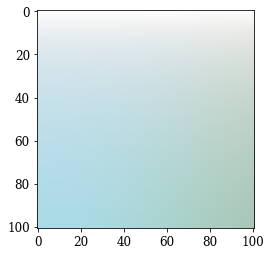

In [13]:
# encoding eigenvalues to normalized image to inspect artifacts
α_im = α.copy()

α_im[...,0] /= α_im[...,0].max()
α_im[...,1] /= α_im[...,1].max()
α_im[...,2] /= α_im[...,2].max()

plt.imshow(α_im)

No artifacts or deviations are visible; surface looks clean.

In [14]:
np.save('eigenvalues.npy', α)